 use neural network to predict the change in the ecmwf-eps from the previous cycle run 12 hours ago for days 9-14
 ### current model features
- the difference between the new ecmwf forecast for day 9 and the previous emcwf-eps forecast for day 9[x]
- the difference between the new emcwf-eps forecast for day 8 and the previous emcwf-eps forecast for day 8[x]
- the difference between the new gfs-ens-bc forecast for days 9-14 and the previous emcwf-eps forecast for days 9-14[x]
- the difference between the new cmc-ens forecast for days 9-14 and the new gfs-ens-bc  forecast for days 9-14[x]

### new feature ideas
- rain data
- wind data
- past errors
- ???

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from datetime import datetime, time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import copy
from meteostat import Stations, Daily

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [67]:
path = "RawData"

In [68]:
def extract_date_time(filename):
    """
    extract the date and time from the filename
    :param filename:
    :return:
    """
    parts = filename.split('.')
    date = parts[1]
    time = parts[2]
    return date, time

In [69]:
def get_date(df, file):
    """get the date from the dataframe and the time from the filename and combine them into a datetime object
    :param df: dataframe containing the date
    :param file: filename containing the time
    :return: datetime object
    """
    #date_str = df[df.iloc[:, 2] == 1].iloc[0]['Date']
    date_str = str(file.split('.')[1])
    time_str = str(file.split('.')[2])
    #date = datetime.strptime(date_str, '%Y-%m-%d')
    date = datetime.strptime(date_str, '%Y%m%d')
    time_value = time(int(time_str), 0)
    combined_datetime = datetime.combine(date.date(), time_value)
    return combined_datetime

In [70]:
ecmwf_files = glob.glob(path + '/ecmwf.*.[01][02].gw_hdd.csv')
ecmwf_sorted_files = sorted(ecmwf_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[3:]

ecmwf_eps_files = glob.glob(path + '/ecmwf-eps.*.[01][02].gw_hdd.csv')
ecmwf_eps_sorted_files = sorted(ecmwf_eps_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

gfs_ens_bc_files = glob.glob(path + '/gfs-ens-bc.*.[01][02].gw_hdd.csv')
gfs_ens_bc_sorted_files = sorted(gfs_ens_bc_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

cmc_ens_files = glob.glob(path + '/cmc-ens.*.[01][02].gw_hdd.csv')
cmc_ens_sorted_files = sorted(cmc_ens_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

In [71]:
for _ in range(2):
    set1 = set((extract_date_time(filename) for filename in ecmwf_sorted_files))
    set2 = set((extract_date_time(filename) for filename in ecmwf_eps_sorted_files))

    ecmwf_sorted_files = [filename for filename in ecmwf_sorted_files if extract_date_time(filename) in set2]
    ecmwf_eps_sorted_files = [filename for filename in ecmwf_eps_sorted_files if extract_date_time(filename) in set1]
    cmc_ens_sorted_files = [filename for filename in cmc_ens_sorted_files if extract_date_time(filename) in set1]

    master_set = set((extract_date_time(filename) for filename in cmc_ens_sorted_files))
    gfs_ens_bc_sorted_files = [filename for filename in gfs_ens_bc_sorted_files if extract_date_time(filename) in master_set]

    master_set = set((extract_date_time(filename) for filename in gfs_ens_bc_sorted_files))

    ecmwf_sorted_files = [filename for filename in ecmwf_sorted_files if extract_date_time(filename) in master_set]
    ecmwf_eps_sorted_files = [filename for filename in ecmwf_eps_sorted_files if extract_date_time(filename) in master_set]
    gfs_ens_bc_sorted_files = [filename for filename in gfs_ens_bc_sorted_files if extract_date_time(filename) in master_set]
    cmc_ens_sorted_files = [filename for filename in cmc_ens_sorted_files if extract_date_time(filename) in master_set]

In [72]:
print(len(ecmwf_sorted_files))
print(len(ecmwf_eps_sorted_files))
print(len(gfs_ens_bc_sorted_files))
print(len(cmc_ens_sorted_files))

3484
3484
3484
3484


### step 1 get changes in ecmwf-eps compared to 12 hours ago for days 9-14

In [73]:
ecmwf_eps_change_df = pd.DataFrame(columns=['ecmwf-eps_9', 'ecmwf-eps_10', 'ecmwf-eps_11', 'ecmwf-eps_12',
                                  'ecmwf-eps_13', 'ecmwf-eps_14'])

for i in range(1, len(ecmwf_eps_sorted_files)):
    ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i])
    prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
    date = get_date(ecmwf_eps_df, ecmwf_eps_sorted_files[i])
    prev_date = get_date(prev_ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 != d1:
        offset = 1
    else:
        offset = 0

    changes = []
    for day in range(8, 14):
        changes.append(ecmwf_eps_df.iloc[day - offset]['Value'] - prev_ecmwf_eps_df.iloc[day]['Value'])
    new_row = pd.DataFrame([changes], columns=ecmwf_eps_change_df.columns, index=[date])
    ecmwf_eps_change_df = pd.concat([ecmwf_eps_change_df, new_row])


## step 2 recreate model

### step 2.1 get difference between the new ecmwf forecast for day 9 and the previous ecmwf-eps forecast for day 9

### problems:
- not all dates are in both sets of data

In [74]:
ecmwf_change_df = pd.DataFrame(columns=['ecmwf_diff_8', 'ecmwf_diff_9',])
for i in range(1, len(ecmwf_sorted_files)):
    ecmwf_df = pd.read_csv(ecmwf_sorted_files[i])
    ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1]) #one day behind

    ecmwf = ecmwf_df.iloc[8]
    ecmwf_eps = ecmwf_eps_df.iloc[9]

    date = get_date(ecmwf_df, ecmwf_sorted_files[i])
    prev_date = get_date(ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]
    if d2 != d1:
        offset = 1
    else:
        offset = 0

    changes = []
    for day in range(8,10):
        changes.append(ecmwf_df.iloc[day - offset]['Value'] - ecmwf_eps_df.iloc[day]['Value'])
    new_row = pd.DataFrame([changes], columns=ecmwf_change_df.columns, index=[date])
    ecmwf_change_df = pd.concat([ecmwf_change_df, new_row])

In [75]:
#ecmwf_change_df

### step 2.2 the difference between the new emcwf-eps forecast for day 8 and the previous emcwf-eps forecast for day 8 (not possible as the new ecmwf-eps forecast is not available because it will not be released yet???)

### step 2.3 the difference between the new gfs-ens-bc forecast for days 9-14 and the previous emcwf-eps forecast for days 9-14

In [165]:
gfs_ens_bc_change_df = pd.DataFrame(columns=['gfs-ens-bc_9', 'gfs-ens-bc_10', 'gfs-ens-bc_11', 'gfs-ens-bc_12',
                                  'gfs-ens-bc_13', 'gfs-ens-bc_14'])

for i in range(1, len(gfs_ens_bc_sorted_files)):
    gfs_ens_bc_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
    prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])

    date = get_date(gfs_ens_bc_df, gfs_ens_bc_sorted_files[i])
    prev_date = get_date(prev_ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]
    if d2 != d1:
        offset = 1
    else:
        offset = 0

    changes = []
    for day in range(8, 14):
        changes.append(gfs_ens_bc_df.iloc[day - offset]['Value'] - prev_ecmwf_eps_df.iloc[day]['Value'])
    new_row = pd.DataFrame([changes], columns=gfs_ens_bc_change_df.columns, index=[date])
    gfs_ens_bc_change_df = pd.concat([gfs_ens_bc_change_df, new_row])

In [166]:
#gfs_ens_bc_change_df

### step 2.4 the difference between the new cmc-ens forecast for days 9-14 and the new gfs-ens-bc  forecast for days 9-14

In [167]:
cmc_ens_change_df = pd.DataFrame(columns=['cmc-ens_9', 'cmc-ens_10', 'cmc-ens_11', 'cmc-ens_12',
                                  'cmc-ens_13', 'cmc-ens_14'])

for i in range(1, len(cmc_ens_sorted_files)):
    cmc_ens_df = pd.read_csv(cmc_ens_sorted_files[i])
    gfs_ens_bc_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
    date = get_date(cmc_ens_df, cmc_ens_sorted_files[i])

    changes = []
    for day in range(8, 14):
        changes.append(cmc_ens_df.iloc[day]['Value'] - gfs_ens_bc_df.iloc[day]['Value'])
    new_row = pd.DataFrame([changes], columns=cmc_ens_change_df.columns, index=[date])
    cmc_ens_change_df = pd.concat([cmc_ens_change_df, new_row])

### new features

In [ ]:
#past errors

In [191]:
errors_df = pd.DataFrame(columns=['error_9', 'error_10', 'error_11', 'error_12', 'error_13', 'error_14'])

for i in range(2, len(ecmwf_eps_sorted_files)):
    ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
    prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-2])
    date = get_date(ecmwf_eps_df, ecmwf_eps_sorted_files[i])
    prev_date = get_date(prev_ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 != d1:
        offset = 1
    else:
        offset = 0

    errors = []
    for day in range(8, 14):
        errors.append(ecmwf_eps_df.iloc[day - offset]['Value'] - prev_ecmwf_eps_df.iloc[day]['Value'])
    new_row = pd.DataFrame([errors], columns=errors_df.columns, index=[date])
    errors_df = pd.concat([errors_df, new_row])

In [169]:
# add month data

In [170]:
cmc_ens_change_df['month'] = cmc_ens_change_df.index.month

In [171]:
def f(i):
    x = 6
    y = 1-(1 * (abs(x-i)/x))
    return y

In [172]:
cmc_ens_change_df['month'] = cmc_ens_change_df['month'].apply(f)

In [173]:
#add weather data

In [174]:
start_day = gfs_ens_bc_change_df.index[0]
end_day = gfs_ens_bc_change_df.index[-1]

# Set time period
start = datetime(int(str(start_day)[:4]), int(str(start_day)[5:7]), int(str(start_day)[8:10]))
end = datetime(int(str(end_day)[:4]), int(str(end_day)[5:7]), int(str(end_day)[8:10]))

# Get daily data
data = Daily('03779', start, end) #london
data2 = Daily('07149', start, end) #paris
data3 = Daily('10384', start, end) #berlin
data = data.fetch()
data2 = data2.fetch()
data3 = data3.fetch()

In [175]:
temp_data = data[['tavg', 'tmin', 'tmax', 'pres']]
temp_data2 = data2[['tavg', 'tmin', 'tmax', 'pres']]
temp_data3 = data3[['tavg', 'tmin', 'tmax', 'pres']]
df_concat = pd.concat([temp_data, temp_data2, temp_data3])
temp_data = df_concat.groupby(df_concat.index).mean()
temp_data = temp_data.diff(1)
temp_data.fillna(0, inplace=True)
temp_data['date'] = temp_data.index.date

In [176]:
gfs_ens_bc_change_df['date'] = gfs_ens_bc_change_df.index.date
merged_df = pd.merge(gfs_ens_bc_change_df, temp_data, on='date', how='left')
merged_df.index = gfs_ens_bc_change_df.index
merged_df.drop(columns=['date'], inplace=True)

In [177]:
gfs_ens_bc_change_df = merged_df

In [193]:
master_df = pd.concat([gfs_ens_bc_change_df, cmc_ens_change_df, ecmwf_change_df, errors_df, ecmwf_eps_change_df], axis=1)

In [194]:
master_df.fillna(0, inplace=True)

In [195]:
display(master_df[:5])

,gfs-ens-bc_9,gfs-ens-bc_10,gfs-ens-bc_11,gfs-ens-bc_12,gfs-ens-bc_13,gfs-ens-bc_14,tavg,tmin,tmax,pres,...,error_11,error_12,error_13,error_14,ecmwf-eps_9,ecmwf-eps_10,ecmwf-eps_11,ecmwf-eps_12,ecmwf-eps_13,ecmwf-eps_14
2018-07-11 00:00:00,0.009,0.006,0.002,0.001,0.013,0.013,0.00,0.00,0.0,0.00,...,0.000,0.000,0.000,0.000,0.001,-0.001,0.000,0.000,0.000,0.000
2018-07-11 12:00:00,0.004,0.001,0.000,0.005,0.008,0.018,0.00,0.00,0.0,0.00,...,-0.001,-0.002,0.002,-0.002,0.001,0.000,-0.001,-0.001,-0.001,-0.001
2018-07-12 00:00:00,0.003,0.002,0.002,0.006,0.009,0.020,0.55,0.65,-1.0,-0.75,...,0.001,0.001,-0.003,0.001,-0.001,-0.001,0.000,0.000,-0.001,0.001
2018-07-12 12:00:00,0.001,0.002,0.004,0.009,0.021,0.015,0.55,0.65,-1.0,-0.75,...,-0.002,0.001,-0.001,0.003,0.000,-0.001,0.001,0.001,0.006,0.003
2018-07-13 00:00:00,0.001,0.002,0.002,0.007,0.019,0.021,2.50,1.65,5.4,2.05,...,0.001,0.000,0.001,0.004,0.000,-0.001,-0.001,-0.002,0.000,-0.001


### random forest - mse=0.1674

In [196]:
X = master_df.iloc[:, :-6]

In [197]:
y = master_df.iloc[:, -6:]

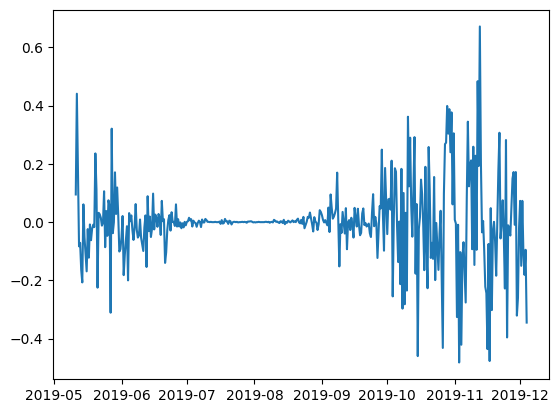

In [198]:
plt.plot(y['ecmwf-eps_9'][600:1000])

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [200]:
rf_model = RandomForestRegressor(n_estimators=1000, max_depth=100, random_state=42)

In [201]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, n_estimators=1000, random_state=42)

In [202]:
y_pred = rf_model.predict(X_test)

In [203]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.18560145213629284


### RNN (MSE): 0.16733

In [204]:
master_df

,gfs-ens-bc_9,gfs-ens-bc_10,gfs-ens-bc_11,gfs-ens-bc_12,gfs-ens-bc_13,gfs-ens-bc_14,tavg,tmin,tmax,pres,...,error_11,error_12,error_13,error_14,ecmwf-eps_9,ecmwf-eps_10,ecmwf-eps_11,ecmwf-eps_12,ecmwf-eps_13,ecmwf-eps_14
2018-07-11 00:00:00,0.009,0.006,0.002,0.001,0.013,0.013,0.000000,0.000000,0.000000,0.000000,...,0.000,0.000,0.000,0.000,0.001,-0.001,0.000,0.000,0.000,0.000
2018-07-11 12:00:00,0.004,0.001,0.000,0.005,0.008,0.018,0.000000,0.000000,0.000000,0.000000,...,-0.001,-0.002,0.002,-0.002,0.001,0.000,-0.001,-0.001,-0.001,-0.001
2018-07-12 00:00:00,0.003,0.002,0.002,0.006,0.009,0.020,0.550000,0.650000,-1.000000,-0.750000,...,0.001,0.001,-0.003,0.001,-0.001,-0.001,0.000,0.000,-0.001,0.001
2018-07-12 12:00:00,0.001,0.002,0.004,0.009,0.021,0.015,0.550000,0.650000,-1.000000,-0.750000,...,-0.002,0.001,-0.001,0.003,0.000,-0.001,0.001,0.001,0.006,0.003
2018-07-13 00:00:00,0.001,0.002,0.002,0.007,0.019,0.021,2.500000,1.650000,5.400000,2.050000,...,0.001,0.000,0.001,0.004,0.000,-0.001,-0.001,-0.002,0.000,-0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15 00:00:00,0.332,0.501,-0.605,-1.101,0.168,0.631,-1.100000,-1.133333,-1.766667,-3.666667,...,-3.790,0.379,1.655,-0.576,0.141,0.055,-0.230,-0.270,-0.257,0.014
2023-05-15 12:00:00,0.403,-0.348,-0.853,0.580,1.175,0.265,-1.100000,-1.133333,-1.766667,-3.666667,...,-0.092,-2.278,-0.519,-0.550,-0.195,-0.020,-0.281,-0.132,0.050,-0.327
2023-05-16 00:00:00,0.336,-0.060,-0.308,0.493,0.187,0.021,-1.166667,-1.200000,-1.966667,5.200000,...,-0.158,1.727,0.130,0.614,-0.035,-0.254,-0.293,-0.192,-0.102,-0.086
2023-05-16 12:00:00,0.203,0.060,1.151,0.556,0.098,-0.652,-1.166667,-1.200000,-1.966667,5.200000,...,-2.051,-0.182,-1.027,0.912,0.261,0.335,0.252,0.221,0.176,0.538


In [205]:
input_features = master_df.iloc[:, :-6].values ** 2
target_variables = master_df.iloc[:, -6:].values

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    input_features, target_variables, test_size=0.2, shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False)

# Scale the input features based on the training data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Scale the validation and test data based on the training data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data to PyTorch tensors

X_train_tensor = torch.Tensor(X_train_scaled)
y_train_tensor = torch.Tensor(y_train)
X_val_tensor = torch.Tensor(X_val_scaled)
y_val_tensor = torch.Tensor(y_val)
X_test_tensor = torch.Tensor(X_test_scaled)
y_test_tensor = torch.Tensor(y_test)


In [206]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Update the hidden state dimensions

        out, _ = self.rnn(x, h0)  # Remove unsqueeze(0) since x already has a batch dimension
        out = self.fc(out[:, -1, :])  # Select the last time step's output for each sequence

        return out

In [207]:
class ComplexRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(ComplexRNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.rnn(x, h0)
        out = self.fc1(out[:, -1, :])
        out = self.dropout(out)
        out = self.fc2(out)

        return out

In [228]:
class ImprovedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(ImprovedRNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 64)  # Dense layer with 64 units
        self.fc2 = nn.Linear(64, output_size)  # Final output layer

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = F.relu(out)  # Apply ReLU activation between LSTM and first dense layer
        out = self.fc1(out[:, -1, :])
        out = F.relu(out)  # Apply ReLU activation to the output of the first dense layer
        out = self.fc2(out)

        return out

In [230]:
input_size = X_train_tensor.shape[1]
output_size = y_train_tensor.shape[1]
hidden_size = 64
num_layers = 2
dropout = 0.3
lr = 0.01



#model = RNN(input_size, hidden_size, output_size)
model = ImprovedRNN(input_size, hidden_size, output_size, num_layers, dropout)
#model = ComplexRNN(input_size, hidden_size, output_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)


num_epochs = 100
sequence_length = 5  # Number of previous days to consider

best_loss = float('inf')
best_model = None

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    # Loop through each sequence in the training data
    for i in range(sequence_length, X_train_tensor.shape[0]):
        # Extract the current sequence and target
        input_seq = X_train_tensor[i - sequence_length:i].view(1, sequence_length, -1)
        target_seq = y_train_tensor[i]

        # Forward pass
        output = model(input_seq)
        loss = criterion(output, target_seq.unsqueeze(0))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 100 == 0:
        average_loss = total_loss / (X_train_tensor.shape[0] - sequence_length)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_loss}')

    # Validation stage
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_val_loss = 0

        for i in range(sequence_length, X_val_tensor.shape[0]):
            input_seq = X_val_tensor[i - sequence_length:i].view(1, sequence_length, -1)
            target_seq = y_val_tensor[i]

            output = model(input_seq)
            val_loss = criterion(output, target_seq.unsqueeze(0))

            total_val_loss += val_loss.item()
        if epoch % 100 == 0:
            average_val_loss = total_val_loss / (X_val_tensor.shape[0] - sequence_length)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {average_val_loss}')

        # Check if current model is the best based on validation loss
        if average_val_loss < best_loss:
            best_loss = average_val_loss
            best_model = copy.deepcopy(model)

# After training, use the best model for testing
model = best_model

Epoch [1/2000], Training Loss: 0.18666494631161137
Epoch [1/2000], Validation Loss: 0.18962318449533563


KeyboardInterrupt: 

In [237]:
#benchmark error
total_mse = 0
c = 0
for i in range(1, len(y_test_tensor)):
    #mse = mean_squared_error(y_test_tensor[i], y_test_tensor[i-1])
    mse = mean_squared_error(y_test_tensor[i], [0,0,0,0,0,0])
    total_mse += mse
    c += 1

total_mse/c

0.16695826363327243

In [238]:
from sklearn.metrics import accuracy_score

In [239]:
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    test_loss = 0.0
    predictions = []

    for i in range(sequence_length, X_test_tensor.shape[0]):
        input_seq = X_test_tensor[i - sequence_length:i].view(1, sequence_length, -1)
        target_seq = y_test_tensor[i]

        output = model(input_seq)
        loss = criterion(output, target_seq.unsqueeze(0))

        test_loss += loss.item()

        # Extract the scalar value from the tensor and append it to predictions
        predictions.append(output.squeeze().tolist())

    average_test_loss = test_loss / (X_test_tensor.shape[0] - sequence_length)
    print(f'Test Loss: {average_test_loss}')

    # Convert the predictions and target values to numpy arrays
    predictions = np.array(predictions)
    targets = y_test_tensor[sequence_length:].numpy()

    # Evaluate the performance using appropriate metrics
    # For example, calculate mean squared error (MSE)
    mse = mean_squared_error(targets, predictions)
    print(f'Mean Squared Error (MSE): {mse}')

Test Loss: 0.16799025009428148
Mean Squared Error (MSE): 0.16799024956394934


In [240]:
def prediction(input):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        input_seq = torch.tensor(input).view(1, sequence_length, -1)
        output = model(input_seq)
        return output.squeeze().tolist()

In [241]:
pred = prediction(X_test_tensor[-5:])

In [242]:
pred

[0.0028527958784252405,
 0.0016104272799566388,
 0.0003809722256846726,
 0.001720474916510284,
 0.0009321747929789126,
 0.0032147488091140985]

In [243]:
y_test_tensor[-1]

tensor([ 0.0000, -0.1690, -0.2710,  0.0250, -0.0080, -0.0780])

### testing ideas


In [33]:
#get weather data

In [147]:
from meteostat import Stations, Daily

start_day = gfs_ens_bc_change_df.index[0]
end_day = gfs_ens_bc_change_df.index[-1]

# Set time period
start = datetime(int(str(start_day)[:4]), int(str(start_day)[5:7]), int(str(start_day)[8:10]))
end = datetime(int(str(end_day)[:4]), int(str(end_day)[5:7]), int(str(end_day)[8:10]))

# Get daily data
#
# 03779 is London
data = Daily('03779', start, end) #london
data2 = Daily('07149', start, end) #paris
data3 = Daily('10384', start, end) #berlin
data = data.fetch()
data2 = data2.fetch()
data3 = data3.fetch()

In [148]:
wind_data = data[['wdir', 'wspd']]

In [149]:
temp_data = data[['tavg', 'tmin', 'tmax', 'pres']]
temp_data2 = data2[['tavg', 'tmin', 'tmax', 'pres']]
temp_data3 = data3[['tavg', 'tmin', 'tmax', 'pres']]

In [150]:
df_concat = pd.concat([temp_data, temp_data2, temp_data3])
averages_df = df_concat.groupby(df_concat.index).mean()

In [151]:
averages_df

,tavg,tmin,tmax,pres
time,,,,
2018-07-11,18.550000,14.400000,23.800000,1016.850000
2018-07-12,19.100000,15.050000,22.800000,1016.100000
2018-07-13,21.600000,16.700000,28.200000,1018.150000
2018-07-14,21.800000,16.200000,27.250000,1018.450000
2018-07-15,22.250000,16.050000,28.250000,1016.150000
...,...,...,...,...
2023-05-13,14.266667,9.733333,19.800000,1022.366667
2023-05-14,13.766667,8.866667,19.733333,1019.300000
2023-05-15,12.666667,7.733333,17.966667,1015.633333


In [116]:
temp_data = temp_data.diff(1)

In [117]:
temp_data.fillna(0, inplace=True)
temp_data['date'] = temp_data.index.date

In [121]:
df_concat = pd.concat([temp_data, temp_data2, temp_data3])

,tavg,tmin,tmax,pres,date
time,,,,,
2018-07-21,0.0,0.0,0.0,0.0,2018-07-21
2018-07-22,0.6,0.5,0.5,2.1,2018-07-22
2018-07-23,2.0,1.5,3.1,0.2,2018-07-23
2018-07-24,-1.1,-0.9,-1.8,-1.7,2018-07-24
2018-07-25,0.3,-0.2,0.9,2.0,2018-07-25
...,...,...,...,...,...
2023-05-13,-0.7,0.6,0.0,2.3,2023-05-13
2023-05-14,-1.1,-0.7,-1.5,-3.9,2023-05-14
2023-05-15,-0.8,-3.4,1.0,-8.5,2023-05-15


In [109]:
stations = Stations()
stations = stations.nearby(52.514903, 13.403915)
station = stations.fetch(5)

In [110]:
station

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
10389,Berlin / Alexanderplatz,DE,BE,10389,<NA>,52.5167,13.4167,37.0,Europe/Berlin,1969-12-01,2011-07-31,1969-12-02,2011-07-31,1970-01-01,2011-01-01,887.896810
10384,Berlin / Tempelhof,DE,BE,10384,EDDI,52.4667,13.4000,50.0,Europe/Berlin,1929-08-01,2023-05-29,1931-01-01,2023-05-27,1931-01-01,2022-01-01,5366.479255
10382,Berlin / Tegel,DE,BE,10382,EDDT,52.5667,13.3167,37.0,Europe/Berlin,1936-03-10,2021-05-05,1936-06-12,2021-05-04,1939-01-01,2021-01-01,8243.869774
ETNB0,Berlin / Reinickendorf,DE,BE,<NA>,ETNB,52.5667,13.3167,36.0,Europe/Berlin,1991-04-21,1991-10-27,NaT,NaT,NaT,NaT,8243.869774
10381,Berlin / Dahlem,DE,BE,10381,<NA>,52.4667,13.3000,51.0,Europe/Berlin,1951-01-01,2023-05-29,1876-01-01,2023-05-27,1876-01-01,2022-01-01,8844.687242


In [61]:
gfs_ens_bc_change_df['date'] = gfs_ens_bc_change_df.index.date

In [62]:
merged_df = pd.merge(gfs_ens_bc_change_df, temp_data, on='date', how='left')

In [63]:
merged_df.index = gfs_ens_bc_change_df.index

In [64]:
merged_df.drop(columns=['date'], inplace=True)

In [65]:
merged_df

,gfs-ens-bc_9,gfs-ens-bc_10,gfs-ens-bc_11,gfs-ens-bc_12,gfs-ens-bc_13,gfs-ens-bc_14,tavg_x,tmin_x,tmax_x,prcp_x,tavg_y,tmin_y,tmax_y,prcp_y
2018-07-11 00:00:00,0.009,0.006,0.002,0.001,0.013,0.013,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2018-07-11 12:00:00,0.004,0.001,0.000,0.005,0.008,0.018,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2018-07-12 00:00:00,0.003,0.002,0.002,0.006,0.009,0.020,-0.7,-2.7,1.3,-0.4,NaN,NaN,NaN,NaN
2018-07-12 12:00:00,0.001,0.002,0.004,0.009,0.021,0.015,-0.7,-2.7,1.3,-0.4,NaN,NaN,NaN,NaN
2018-07-13 00:00:00,0.001,0.002,0.002,0.007,0.019,0.021,2.8,0.4,5.1,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15 00:00:00,0.332,0.501,-0.605,-1.101,0.168,0.631,2.0,1.6,2.7,0.0,-0.8,0.8,-4.9,0.0
2023-05-15 12:00:00,0.403,-0.348,-0.853,0.580,1.175,0.265,2.0,1.6,2.7,0.0,-0.8,0.8,-4.9,0.0
2023-05-16 00:00:00,0.336,-0.060,-0.308,0.493,0.187,0.021,0.6,4.0,-2.3,0.0,-0.9,-2.5,1.7,0.0
2023-05-16 12:00:00,0.203,0.060,1.151,0.556,0.098,-0.652,0.6,4.0,-2.3,0.0,-0.9,-2.5,1.7,0.0


In [ ]:
# get data from EIA short term energy outlook (STEO), such as average heating days

In [ ]:
#use prophet to forecast ecmwf-eps data